In [15]:
import collections
import math
import multiprocessing
import pathlib

import cv2
import matplotlib.patches as pt
import matplotlib.pyplot as plt
import numba
import numpy as np
from PIL import Image
from scipy import ndimage
from tqdm import tqdm

def mean_std(im):
    return (im - im.mean()) / im.std()

def min_max(im):
    return (im - im.min()) / im.max()

# Load elevation from slice

In [ ]:
# ["B1", "B2", "B3", "B4", "B5", "B6_VCID1", "B6_VCID2", "B7", "elevation", "slope"]
# data_dir = pathlib.Path('/home/jperez/data/HKH/processed_L07_2005')
# train_loader, val_loader, test_folder = fetch_loaders(data_dir, batch_size=1,
#                                                       use_channels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
#                                                       normalize='min-max',
#                                                       shuffle=False
#                                                       )

# iter = enumerate(train_loader)
# for _ in range(6):
#     idx, (x, y) = next(iter)
#     print(idx, x.shape, y.shape)

# x = x.numpy()
# y = y.numpy()

# band_idx = 8
# im_rgb = x[0][:, :, [2,1,0]].astype(np.uint8).astype(np.float32)
# # im_rgb = im_rgb[:, :, ::-1] # BGR to RGB
# im_band = x[0][:, :, band_idx]
# print(im_band.shape, im_band.dtype)

band_names = np.array(["B1", "B2", "B3", "B4", "B5", "B6_VCID1", "B6_VCID2", "B7", "elevation", "slope"])
path = '/home/jperez/data/HKH/processed_L07_2005/train/tiff_140_slice_1.npy'
im = np.load(path)
im_rgb = im[:, :, [2, 1, 0]].astype(np.uint8)
im_band = im[:, :, 8]
im_slope = im[:, :, 9]

print(f'RGB statistics | min={im_rgb.min()}, max={im_rgb.max()}')
print(f'Band statistics | min={im_band.min()}, max={im_band.max()}')

fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(30, 30))

ax[0, 0].imshow(im_rgb, cmap='gray')
ax[0, 0].set_title('RGB')
ax[0, 0].set_axis_off()

ax[0, 1].imshow(im_band, cmap='gray')
ax[0, 1].set_title('Elevation Band')
ax[0, 1].set_axis_off()

# ax[1, 0].imshow(x[0][:, :, [2, 1, 0]], cmap='gray')
# ax[1, 0].set_title('RGB')

# mask1 = y[0][:, :, 0]
# overlay = np.stack((im_rgb,)*3, axis=-1)
# overlay[mask1==1] = [0, 0, 1]
# ax[1, 0].imshow(overlay)
# ax[1, 0].set_title('BG')

# mask2 = y[0][:, :, 1]
# overlay = np.stack((im_rgb,)*3, axis=-1)
# overlay[mask2==1] = [1, 0, 0]
# ax[1, 1].imshow(overlay)
# ax[1, 1].set_title('Clean Ice')

## Visualize channels

In [ ]:
for i in range(im.shape[2]):
    plt.figure(figsize=(10,10))
    plt.suptitle(f'Channel {i}={band_names[i]}')
    plt.imshow(im[:,:,i], cmap='gray')

In [ ]:
# 0 to 45 top-left, 46 to 90 left, 91 to 135 bot-left, 136 to 180 down
# 0 to -45 top-right, ...

plt.figure(figsize=(10, 10))
plt.imshow(im_rgb, cmap='gray')

plt.figure(figsize=(10, 10))
plt.imshow(im_band, cmap='gray')

# Gradients
sx = ndimage.sobel(im_band,axis=0,mode='constant')
sy = ndimage.sobel(im_band,axis=1,mode='constant')
theta = np.degrees(np.arctan2(sy,sx))

In [10]:
def get_neighbors(im, coords):
    r, c = coords
    possible = [(r-1, c-1), # bot-left
            (r-1, c), # down
            (r-1, c+1), # bot-right
            (r, c+1), # right
            (r+1, c+1), # top-right
            (r+1, c), # up
            (r+1, c-1), # top-left
            (r, c-1) # left
    ]

    real = []
    for tup in possible:
        tr, tc = tup
        if tr >= 0 and tr < im.shape[0] and tc >= 0 and tc < im.shape[1]:
            real.append(tup)

    return real


def breadth_first_search(im, source):
    visited = set([source])
    prev = np.zeros((im.shape[0], im.shape[1], 2))
    prev[:, :] = -1

    Q = [source]

    min_val = im.min()

    while len(Q)>0:
        u = Q.pop(0)
        curr_elev = im[u]

        if abs(curr_elev - min_val) < 0.1:
            return prev, u
            
        for v in get_neighbors(im, u):
            # Water can only flow down
            neigh_elev = im[v]
            if v not in visited and neigh_elev < curr_elev:
                prev[v] = u
                visited.add(v)
                Q.append(v)
    return prev, -1

def get_path(prev,v):
    prev_tuple = prev[v]
    if prev_tuple.sum()<0:   # v is the origin
        return [v]
    return get_path(prev, (int(prev_tuple[0]), int(prev_tuple[1]))) + [v]

In [ ]:
# Find peaks in elevation
print(im_band.max(), im_band.mean(), im_band.min())
peaks = np.argwhere(im_band > im_band.max() - 0.05)
print(len(peaks))

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(im_rgb, cmap='gray')
for peak in peaks:
    pr, pc = peak[0], peak[1]
    ax.add_patch(pt.Rectangle((pc, pr), 5, 5, fill=True, facecolor=('red'), lw=1))
plt.show()

# for peak in peaks:
peak = peaks[0]
pr, pc = peak[0], peak[1]
prev, goal = breadth_first_search(im_band, (pr, pc))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(im_band, cmap='gray')
for peak in peaks:
    pr, pc = peak[0], peak[1]
    ax.add_patch(pt.Rectangle((pc, pr), 1, 1, fill=True, facecolor=('red'), lw=1))

path = get_path(prev, goal)

for idx in range(len(path)-1):
    (r, c) = path[idx]
    ax.add_patch(pt.Rectangle((c, r), 1, 1, fill=True, facecolor=('blue'), lw=1))

In [5]:
@numba.njit()
def breadth_first_search(im, source):
    visited = set([source])
    prev = np.zeros((im.shape[0], im.shape[1], 2))
    prev[:, :] = -1

    Q = [source]

    min_val = im.min()

    best_u = source
    best_elev = im[source]

    while len(Q)>0:
        u = Q.pop(0)
        curr_elev = im[u]

        # if abs(curr_elev - min_val) < 0.01:
        #     return prev, u

        if curr_elev < best_elev:
            best_elev = curr_elev
            best_u = u
            
        for v in get_neighbors(im, u):
            # Water can only flow down
            neigh_elev = im[v]
            if v not in visited and neigh_elev < curr_elev:
                prev[v] = u
                visited.add(v)
                Q.append(v)
    return prev, best_u

@numba.njit()
def get_path(prev,v):
    prev_tuple = prev[v]
    if prev_tuple.sum()<0:   # v is the origin
        return [v]
    return get_path(prev, (int(prev_tuple[0]), int(prev_tuple[1]))) + [v]

In [17]:
print(im_band.shape)
pairs = []
for p in np.mgrid[0:im_band.shape[0]:50j, 0:im_band.shape[1]:50j].reshape(2,-1).T:
    pairs.append([int(p[0]), int(p[1])])
# print(pairs)
# u, v = tuple
# prev, goal = breadth_first_search(im_band, (u, v))
# if goal is None:
#     return

# path = get_path(prev, goal)
# return path

(512, 512)


In [ ]:
water = np.load('water.npy')
k = 100
ind = np.argpartition(water.flatten(), -k)[-k:]
topk = sorted(water.flatten()[ind])
print(water)
print(water.min(), water.max(), water.mean(), topk)
print(np.sum(water < water.mean()))
print(np.sum(water >= water.mean()))

# t = 2*water.mean()
# print(np.sum(water > t))
# water[water < t] = 0
# water[water >= t] = 1
mask = water > 80

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(40, 40))
ax[0].imshow(im_band, cmap='gray')

# overlay = np.stack((im_rgb,)*3, axis=-1)
# overlay[mask==1] = [1, 0, 0]
# ax[1].imshow(overlay, cmap='gray')

ax[1].imshow(water, cmap='gray')

overlay = np.stack((im_band,)*3, axis=-1)
overlay[mask==1] = [1, 0, 0]
ax[2].imshow(overlay, cmap='gray')

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(im_band[250:400, 100:200])


plt.figure(figsize=(15, 15))
plt.imshow(im_band[300:350, 100:200])

plt.figure(figsize=(15, 15))
plt.imshow(im_band[310:340, 135:155])

print(im_band[325, 125:155])

-Gradient descent to local minima
-Simulate rainfall*
-Every iteration changes elevation
-Water to every BFS visit
-DEM

-Run UNet to add experiments

In [22]:
# StandardScaler for all elevation maps
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm 

scaler = StandardScaler()
for fpath in tqdm(list(pathlib.Path('/home/jperez/data/HKH/processed_L07_2005/train/').glob('*tiff*'))):
    arr = np.load(fpath)
    scaler.fit(arr[:, :, 8])

100%|██████████| 314/314 [00:01<00:00, 266.43it/s]


In [ ]:
# Normalize elevation map to [0,1]
# water = (im_band - im_band.mean()) / im_band.std() # mean-std (min=-6.59, mean=-0.00, max=3.65, std=1.00)
water = (im_band - im_band.min()) / im_band.max() # min-max (min=0.00, mean=0.64, max=1.00, std=0.10)
# water = scaler.transform(im_band) # StandardScaler (min=-6.83, mean=63.27, max=6111.00, std=569.76)

print(f'min={water.min():.2f}, mean={water.mean():.2f}, max={water.max():.2f}, std={water.std():.2f}')

plt.figure(figsize=(15, 15))
plt.imshow(water, cmap='gray')

# plt.figure(figsize=(15, 15))
# water_overlay = np.stack((water,)*3, axis=-1)
# # mask = water>0.8
# # water_overlay[mask] = (1, 0, 0)
# plt.imshow(water_overlay)
# print(mask.sum(), f'{(mask.sum()/(water.shape[0]*water.shape[1]))*100:.2f}%')

# Whole images

100%|██████████| 6/6 [00:06<00:00,  1.10s/it]

10M	dem114.npy
3.3M	dem114.npz
11M	dem134.npy
3.2M	dem134.npz
12M	dem145.npy
4.1M	dem145.npz
12M	dem166.npy
3.4M	dem166.npz
12M	dem51.npy
4.0M	dem51.npz
12M	dem58.npy
4.4M	dem58.npz


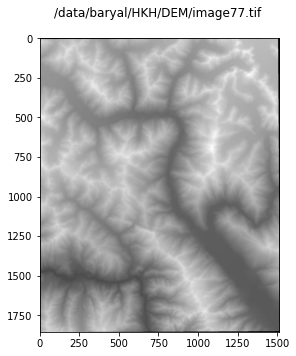

In [49]:
# Save some images for Dr. Fuentes
import glacier_mapping.segmentation.data.slice as fn

def get_elevation_slope(tiff_path):
    dem = fn.read_tiff(tiff_path)
    dem_np = np.transpose(dem.read(), (1, 2, 0)).astype(np.float32)
    dem_np = np.nan_to_num(dem_np)
    elevation = dem_np[:,:,0][:,:,None]
    slope = dem_np[:,:,1][:,:,None]
    slope = np.sin(slope*np.pi/180)
    return elevation, slope

all_files = list(pathlib.Path('/data/baryal/HKH/DEM/').glob('*.tif'))
random_path = np.random.choice(all_files, 1)[0]
plt.figure(figsize=(5, 5))
plt.suptitle(random_path)
plt.imshow(get_elevation_slope(random_path)[0], cmap='gray')
plt.tight_layout()

# 145, 51, 134, 114, 166, 58
for i in tqdm([145, 51, 134, 114, 166, 58]):
    elevation, slope = get_elevation_slope(pathlib.Path(f'/data/baryal/HKH/DEM/image{i}.tif'))
    # np.save(f'dem{i}.npy', elevation)
    np.savez_compressed(f'dem{i}.npz', elevation=elevation)

!du dem* -h

 83%|████████▎ | 5/6 [00:00<00:00, 22.12it/s]

True
True
True
True
True


100%|██████████| 6/6 [00:00<00:00, 21.71it/s]


True


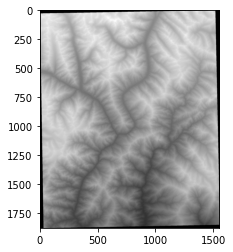

In [54]:
import numpy as np

for n in [145, 51, 134, 114, 166, 58]:
    elevation = np.load(f'dem{n}.npz')['elevation']
    plt.imshow(elevation, cmap='gray')

# elevation2 = np.load(f'dem{i}.npy')
# print(np.array_equal(elevation, elevation2))

(1900, 1610, 1) -> (570, 483) 0.0 6665.0 float32
(570, 483) 0.0 0.99607843 float32


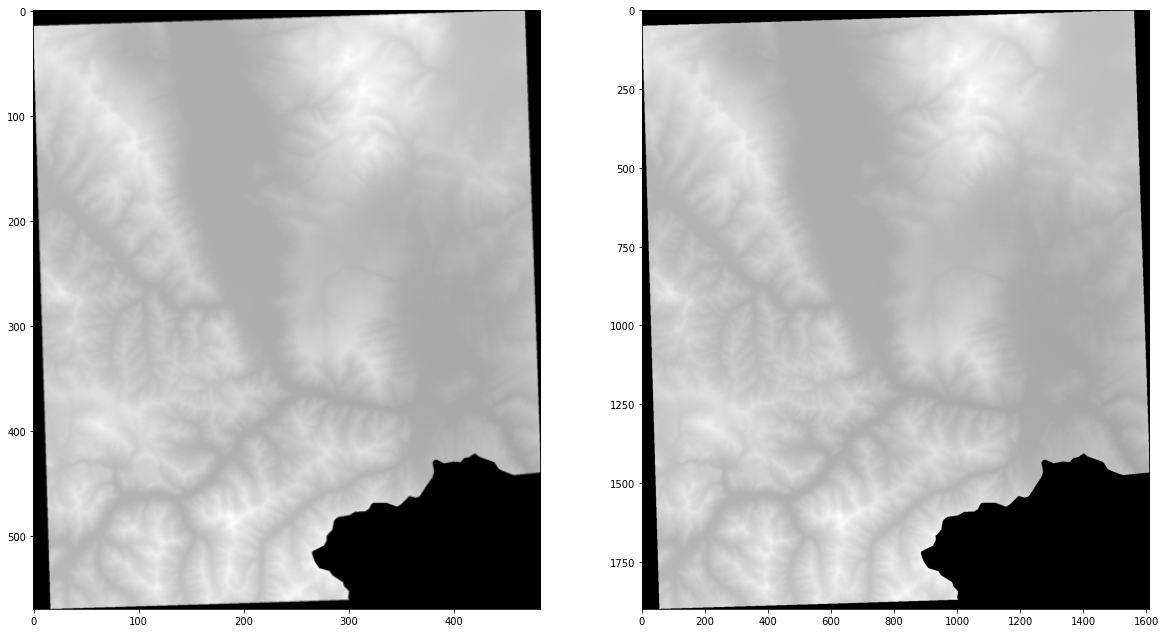

In [18]:
import glacier_mapping.segmentation.data.slice as fn


def resize(arr, new_rows, new_cols):
    arr = min_max(arr)*255
    arr = arr.astype(np.uint8).reshape(arr.shape[0], arr.shape[1])
    arr = np.array(Image.fromarray(arr).resize((new_cols, new_rows), Image.BILINEAR))
    arr = (arr / 255).astype(np.float32)
    return arr

dem = fn.read_tiff('/data/baryal/HKH/DEM/image1.tif')
dem_np = np.transpose(dem.read(), (1, 2, 0)).astype(np.float32)
dem_np = np.nan_to_num(dem_np)
elevation = dem_np[:,:,0][:,:,None]
slope = dem_np[:,:,1][:,:,None]
slope = np.sin(slope*np.pi/180)

# Resize
new_rows = int(elevation.shape[0] * 0.3)
new_cols = int(elevation.shape[1] * 0.3)
print(elevation.shape, '->', (new_rows, new_cols), elevation.min(), elevation.max(), elevation.dtype)

orig_elevation = elevation
elevation = resize(orig_elevation, new_rows, new_cols)

fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(elevation, cmap='gray')
ax[1].imshow(orig_elevation, cmap='gray')

print(elevation.shape, elevation.min(), elevation.max(), elevation.dtype)

# BFS v2

In [32]:
def cost(u, v):
    return np.log(np.linalg.norm(u-v))

print(distance(np.array([0,0]), np.array([0,15])))

# np.log(distance(np.array([0,0]), np.array([0,1500])))

cost2(np.array([0,0]), np.array([0,15]), (100, 100))

15.0


TypeError: return arrays must be of ArrayType

In [42]:
@numba.njit()
def get_neighbors(im, coords):
    r, c = coords
    possible = [(r-1, c-1), # bot-left
            (r-1, c), # down
            (r-1, c+1), # bot-right
            (r, c+1), # right
            (r+1, c+1), # top-right
            (r+1, c), # up
            (r+1, c-1), # top-left
            (r, c-1) # left
    ]

    real = []
    for tup in possible:
        tr, tc = tup
        if tr >= 0 and tr < im.shape[0] and tc >= 0 and tc < im.shape[1]:
            real.append(tup)

    return real

@numba.njit()
def get_path(prev,v):
    prev_tuple = prev[v]
    if prev_tuple.sum()<0:   # v is the origin
        # L = numba.typed.List()
        L = []
        L.append(v)
        return L
    L = get_path(prev, (int(prev_tuple[0]), int(prev_tuple[1])))
    L.append(v)
    return L

def cost(u, v):
    return np.log(np.linalg.norm(u-v))

# @numba.njit()
def cost2(u, v, shape):
    n1 = u[1] + (u[0] * shape[1])
    n2 = v[1] + (v[0] * shape[1])
    return 1/math.log(n1, n2)

@numba.njit()
def cost3(u, v):
    rr = abs(u[0] - v[0])
    cc = abs(u[1] - v[1])
    return (rr + cc)

def breadth_first_search_v2(im, water_allpath, source):
    visited = set([source])
    # prev = np.zeros((im.shape[0], im.shape[1], 2))
    # prev[:, :] = -1

    Q = collections.deque()
    Q.append(source)

    # min_val = im.min()
    # best_u = source
    # best_elev = im[source]

    # iters = 0
    while len(Q) > 0:
        # iters += 1
        u = Q.popleft()
        curr_elev = im[u]
        
        # Only accumulate water in neighbors
        if u != source:
            water_allpath[u] += cost3(source, u)

        # Keep track of best so far in case we stop early
        # if curr_elev < best_elev:
        #     best_elev = curr_elev
        #     best_u = u

        # Early goal
        # if source != u and abs(curr_elev - min_val) <= 1e-3:
        #     return water_allpath

        # # # Max iterations
        # if iters > 512: # 2^10=1024 | 2^16=65536 -> explored N levels
        #     return water_allpath

        # Get only valid neighbors
        for v in get_neighbors(im, u):
            neigh_elev = im[v]
            # Visit if not visited and if elevation is lower as water can only flow down
            if v not in visited and neigh_elev < curr_elev:
                # prev[v] = u
                visited.add(v)
                Q.append(v)
    
    return water_allpath

# water = (im_band - im_band.min()) / im_band.max()
water = (elevation - elevation.min()) / elevation.max()
water_allpath = np.zeros((water.shape[0], water.shape[1]), dtype=np.float32)
pairs = []
step = complex(0, 128)
for p in np.mgrid[0:water.shape[0]-1:step, 0:water.shape[1]-1:step].reshape(2,-1).T:
    pairs.append((int(p[0]), int(p[1])))

for u,v in tqdm(pairs):
    water_allpath = breadth_first_search_v2(water, water_allpath, (u, v))

# Normalize
water_allpath = mean_std(water_allpath)

# Resize
new_rows = orig_elevation.shape[0]
new_cols = orig_elevation.shape[1]
water_allpath = resize(water_allpath, new_rows, new_cols)

100%|██████████| 16384/16384 [00:04<00:00, 3541.89it/s]


0.0 0.020955466 0.972549


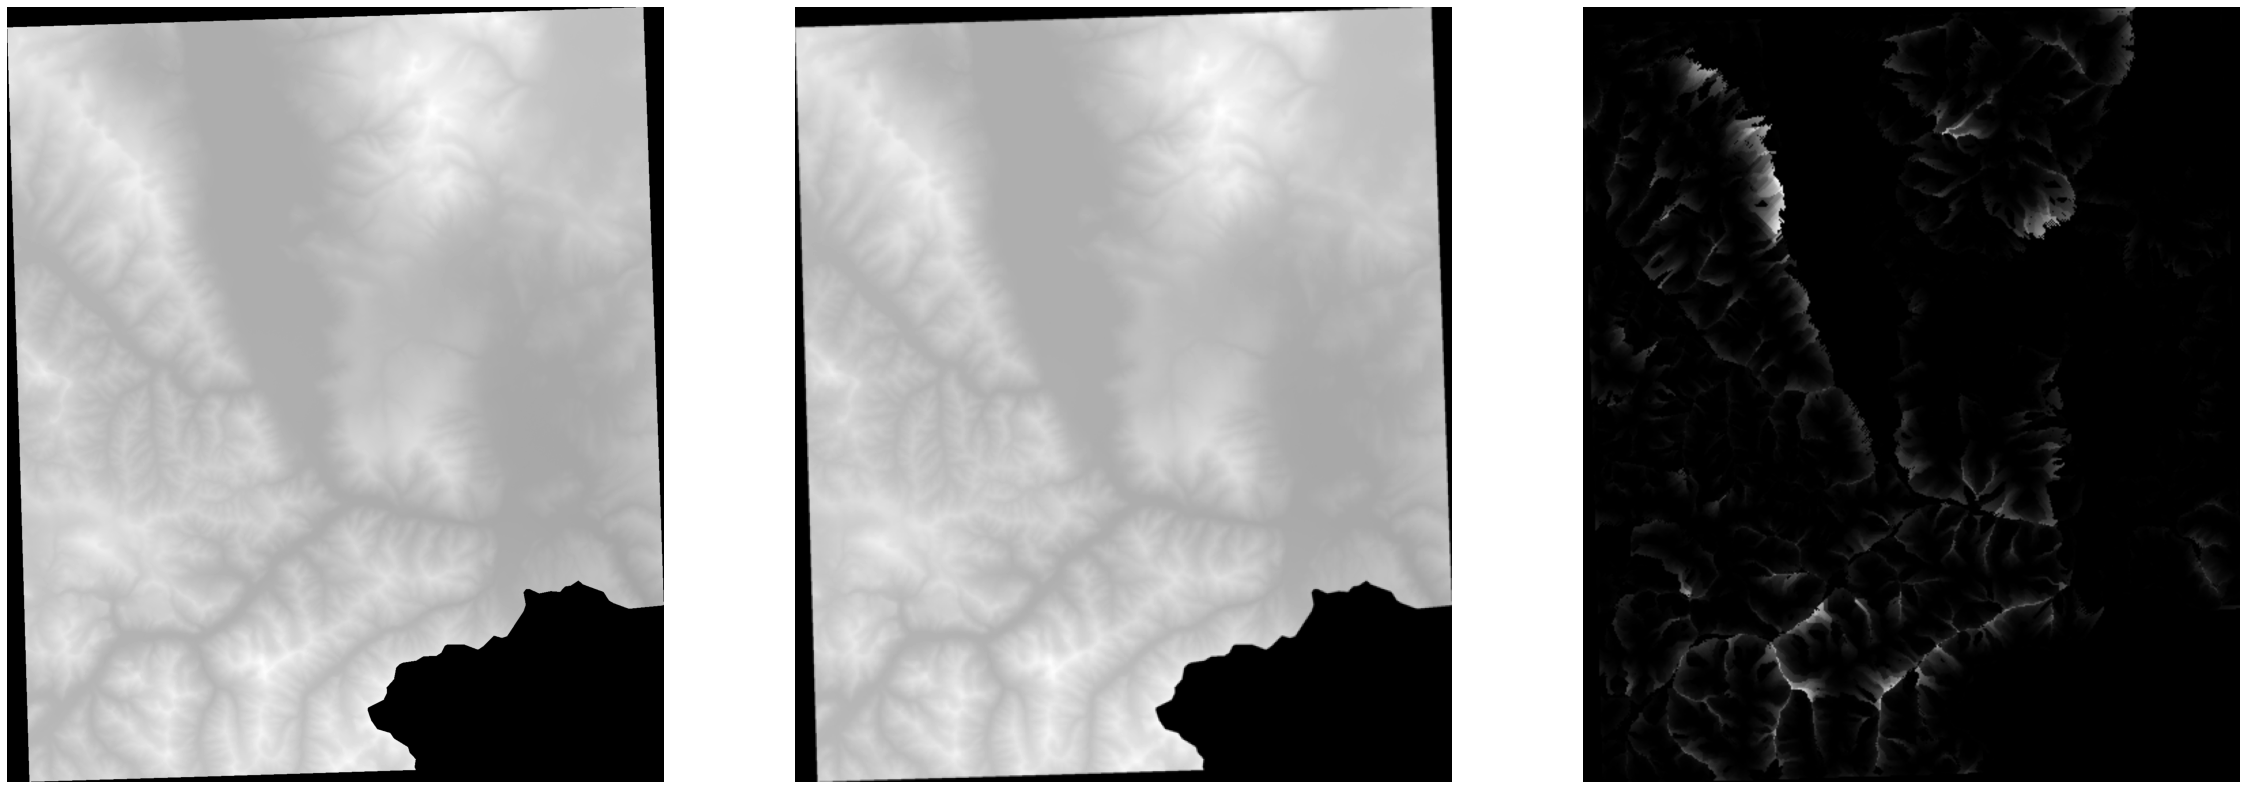

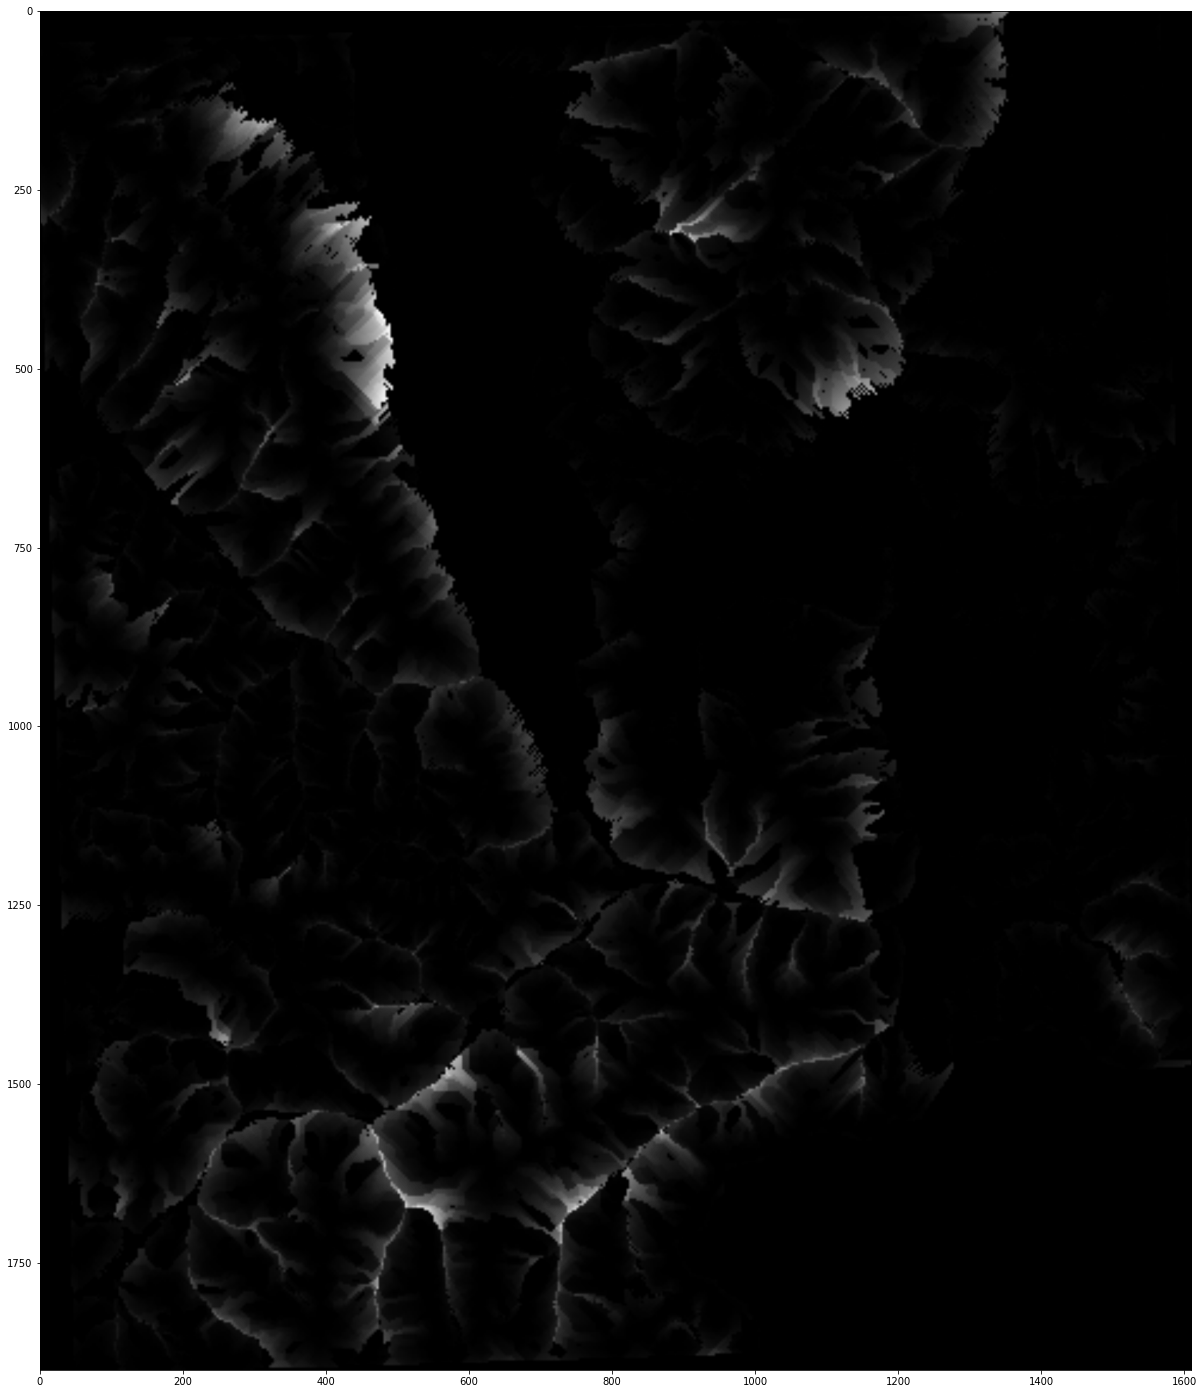

In [43]:
print(water_allpath.min(), water_allpath.mean(), water_allpath.max())

nrows=1
ncols=3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(40, 20))

for i in range(nrows):
    for j in range(ncols):
        if nrows==1:
            dax: plt.Axes = ax[j]
        elif ncols==1:
            dax: plt.Axes = ax[i]
        else:
            dax: plt.Axes = ax[i,j]
        dax.set_axis_off()

ax[0].imshow(orig_elevation, cmap='gray')
ax[1].imshow(water, cmap='gray')
ax[2].imshow(water_allpath, cmap='gray')
# ax[3].imshow(im_slope, cmap='gray')

plt.figure(figsize=(25,25))
plt.imshow(water_allpath, cmap='gray')

In [98]:
def breadth_first_search_v3(im, source):
    visited = set([source])
    prev = np.zeros((im.shape[0], im.shape[1], 2))
    prev[:, :] = -1

    Q = collections.deque()
    Q.append(source)

    min_val = im.min()
    best_u = source
    best_elev = im[source]

    iters = 0
    while len(Q) > 0:
        iters += 1
        u = Q.popleft()
        curr_elev = im[u]

        # Keep track of best so far in case we stop early
        if curr_elev < best_elev:
            best_elev = curr_elev
            best_u = u

        # Early goal
        if source != u and abs(curr_elev - min_val) <= 1e-3:
            return im, prev, best_u

        # Max iterations
        if iters > 512: # 2^10=1024 | 2^16=65536 -> explored N levels
            return im, prev, best_u

        # Get only valid neighbors
        for v in get_neighbors(im, u):
            neigh_elev = im[v]
            # Visit if not visited and if elevation is lower as water can only flow down
            if v not in visited and neigh_elev < curr_elev:
                prev[v] = u
                visited.add(v)
                Q.append(v)
    
    return im, prev, best_u

water = (im_band - im_band.min()) / im_band.max()
water_allpath = np.zeros((im.shape[0], im.shape[1]), dtype=np.float32)
pairs = []
for p in np.mgrid[0:water.shape[0]-1:128j, 0:water.shape[1]-1:128j].reshape(2,-1).T:
    pairs.append((int(p[0]), int(p[1])))

for u,v in tqdm(pairs):
    water, prev, best_u = breadth_first_search_v3(water, (u, v))
    path = get_path(prev, best_u)
    contribution = np.linspace(0, 1 / (len(path) / 2), len(path))
    water_level = np.linspace(0, 1, len(path))
    for idx, (r, c) in enumerate(path):
        water_allpath[r, c] += contribution[idx]
        water[r, c] += water_level[idx]

100%|██████████| 16384/16384 [00:21<00:00, 760.98it/s]
